Differential gene expression of cancers subtypes

In [84]:
import pandas as pd
import numpy as np
import scanpy as sc
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import tifffile
import pickle
import glob
from copy import deepcopy
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.patches as mpatches
import anndata as ad
from scipy.io import mmread
import random
import os
import sys
import seaborn as sns
import time

import squidpy as sq

In [85]:
region_adata = ad.read(f'/mnt/nkeener/test_data/human_tumor/lung/labeled_adata_new_filters_fixed_regions.h5ad')
region_adata.obs

,volume,z0_coords,z1_coords,z2_coords,z3_coords,z4_coords,z5_coords,z_count,n_genes_by_counts,log1p_n_genes_by_counts,...,pct_counts_in_top_500_genes,n_counts,n_genes,leiden_main,cell_type_manual_major,int_type,cell_type_manual_minor1,cell_type_manual_minor2,cell_type_manual_minor3,region
111187,23301,29673_20667,29670_20682,29669_20681,29667_20682,29666_20681,29663_20680,6,57,4.060443,...,100.0,130.0,57,0,Endothelial,1,Blood vessels,NaN,NaN,Stromal
436128,14738,18651_56485,18654_56491,18659_56494,18663_56497,18667_56502,18670_56504,6,78,4.369448,...,100.0,178.0,78,0,Endothelial,1,Blood vessels,NaN,NaN,Immune Hub
458993,19287,3176_62841,3182_62842,3186_62842,3191_62842,3197_62846,3201_62849,6,35,3.583519,...,100.0,51.0,35,0,Endothelial,1,Blood vessels,NaN,NaN,Stromal
25109,7222,14289_10372,14288_10376,14288_10378,14286_10385,0,0,4,42,3.761200,...,100.0,96.0,42,0,Endothelial,1,Blood vessels,NaN,NaN,Stromal
233562,29475,62621_33210,62631_33227,62627_33226,62616_33224,62615_33232,62613_33240,6,121,4.804021,...,100.0,334.0,121,0,Endothelial,1,Blood vessels,NaN,NaN,Immune Hub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273365,62430,7360_42539,7359_42537,7358_42536,7355_42535,7349_42522,7348_42508,6,124,4.828314,...,100.0,610.0,124,1,Epithelial,3,Cancer Epithelial,Cancer Subtype 2,NaN,Structured Epithelial
314243,57670,14296_45009,14295_45011,14293_45014,14292_45016,14291_45020,14292_45019,6,98,4.595120,...,100.0,338.0,98,3,Epithelial,0,Cancer Epithelial,Cancer Subtype 1,NaN,Structured Epithelial
300365,25839,48507_41733,48504_41733,48503_41731,48503_41731,0,0,4,46,3.850148,...,100.0,132.0,46,1,Epithelial,3,Cancer Epithelial,Cancer Subtype 2,NaN,Structured Epithelial
56022,36863,35012_14989,35008_14988,35004_14988,35009_14989,35003_14992,34985_14994,6,111,4.718499,...,100.0,514.0,111,1,Epithelial,3,Cancer Epithelial,Cancer Subtype 2,NaN,Structured Epithelial


In [86]:
# Create dictionary mapping of cell index to cell integer type
minor1 = list(region_adata.obs['cell_type_manual_minor1'])
region_adata.obs['cell_type_manual_minor2'] = [celltype if celltype == celltype else minor1[c] for c, celltype in enumerate(region_adata.obs['cell_type_manual_minor2'])]

name_map = {'Cancer Subtype 1': 'Cancer Subtype 1',
            'Cancer Subtype 2': 'Cancer Subtype 2',
            'Cancer Subtype 3': 'Cancer Subtype 3',
            'Alveolar Epithelium': 'Alveolar Epithelial',
            'B cell lineage': 'B-cells',
            'T cell lineage': 'T-cells',
            'Dendritic cells': 'Dendritic cells',
            'Macrophages': 'Macrophages',
            'Monocytes': 'Monocytes',
            'Mast cells': 'Mast cells',
            'Fibroblast lineage': 'Fibroblasts',
            'Smooth muscle': 'Smooth muscle',
            'Blood vessels': 'Blood vessels',
            'Lymphatic EC': 'Lymphatic EC',
            'Unassigned Myeloid': 'Unassigned Myeloid'}
region_adata.obs['new_ann'] = [name_map[celltype] for celltype in region_adata.obs['cell_type_manual_minor2']]
region_adata.obs['new_ann'] = pd.Categorical(region_adata.obs['new_ann'])

In [87]:
Counter(region_adata.obs['new_ann'])

Counter({'Blood vessels': 6695,
         'Lymphatic EC': 616,
         'T-cells': 32044,
         'B-cells': 11812,
         'Monocytes': 17959,
         'Unassigned Myeloid': 1347,
         'Macrophages': 10073,
         'Mast cells': 462,
         'Dendritic cells': 260,
         'Fibroblasts': 20459,
         'Smooth muscle': 7306,
         'Cancer Subtype 1': 148465,
         'Cancer Subtype 3': 57606,
         'Cancer Subtype 2': 77530,
         'Alveolar Epithelial': 44271})

In [88]:
oncogenes = ['KRAS', 'HRAS', 'SOX2', 'SOX9', 'EGFR', 'RAF1', 'BRAF', 'KIT', 'MYC', 'ETS1', 'MET', 'NRAS', 'ROS1', 'SRC', 'TBX3', 'BRD4', 'SMO', 'TWIST1', 'IDH1', 'PDK1', 'PDK4', 'NF1']
tumor_suppressor = ['TP53', 'TP63', 'RB1', 'PTEN']

In [89]:
# Subset for each cancer region
cancer_1 = region_adata[np.isin(region_adata.obs['new_ann'], ['Cancer Subtype 1'])]
cancer_2 = region_adata[np.isin(region_adata.obs['new_ann'], ['Cancer Subtype 2'])]
cancer_3 = region_adata[np.isin(region_adata.obs['new_ann'], ['Cancer Subtype 3'])]

# Combine
cancer_combine = sc.concat([cancer_1, cancer_2, cancer_3])

cancer_combine

AnnData object with n_obs × n_vars = 283601 × 500
    obs: 'volume', 'z0_coords', 'z1_coords', 'z2_coords', 'z3_coords', 'z4_coords', 'z5_coords', 'z_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'leiden_main', 'cell_type_manual_major', 'int_type', 'cell_type_manual_minor1', 'cell_type_manual_minor2', 'cell_type_manual_minor3', 'region', 'new_ann'
    obsm: 'X_pca', 'X_umap'

In [91]:
# Find the most differentially expressed genes between cancer 1 and cancer 2
sc.tl.rank_genes_groups(cancer_combine, 'new_ann', method='wilcoxon')
marker_df = sc.get.rank_genes_groups_df(cancer_combine, group=None)

# Add -log10(pvals_adj) column
pmin = np.min(marker_df[marker_df['pvals_adj'] != 0]['pvals_adj'])
marker_df['pvals_adj'] = [pval if pval > 10**-308 else pmin for pval in marker_df['pvals_adj']]
marker_df['-log10(pvals_adj)'] = -np.log10(marker_df['pvals_adj'])

marker_df

/mnt/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/mnt/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/mnt/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


,group,names,scores,logfoldchanges,pvals,pvals_adj,-log10(pvals_adj)
0,Cancer Subtype 1,PKM,239.927078,3.964855,0.0,2.703817e-309,308.568023
1,Cancer Subtype 1,MCM2,231.703400,NaN,0.0,2.703817e-309,308.568023
2,Cancer Subtype 1,FGFR3,216.742706,NaN,0.0,2.703817e-309,308.568023
3,Cancer Subtype 1,PDPN,195.958054,NaN,0.0,2.703817e-309,308.568023
4,Cancer Subtype 1,CTNNB1,192.885269,NaN,0.0,2.703817e-309,308.568023
...,...,...,...,...,...,...,...
1495,Cancer Subtype 3,MCM2,-135.507370,NaN,0.0,2.703817e-309,308.568023
1496,Cancer Subtype 3,CTNNB1,-145.768646,NaN,0.0,2.703817e-309,308.568023
1497,Cancer Subtype 3,FGFR3,-164.193268,NaN,0.0,2.703817e-309,308.568023
1498,Cancer Subtype 3,S100A9,-185.454956,NaN,0.0,2.703817e-309,308.568023


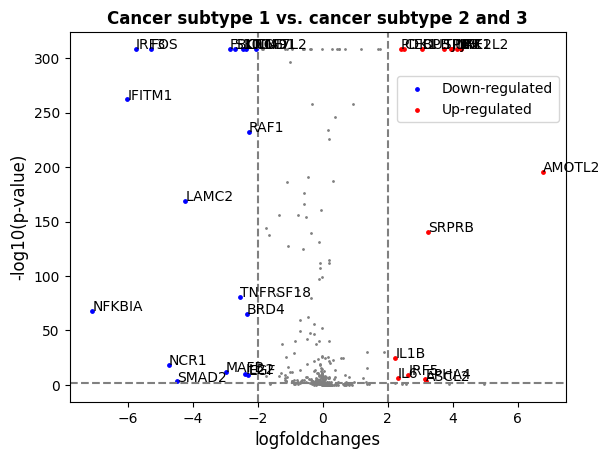

In [105]:
cancer_1_df = marker_df[marker_df['group'] == 'Cancer Subtype 1']

# Volcano plot
plt.scatter(x=cancer_1_df['logfoldchanges'], 
            y=cancer_1_df['-log10(pvals_adj)'],
            s=1,
            color='grey')
plt.title('Cancer subtype 1 vs. cancer subtype 2 and 3', fontweight='bold')

# highlight down- or up-regulated genes
down = cancer_1_df[(cancer_1_df['logfoldchanges'] <= -2) & (cancer_1_df['pvals_adj'] <= 0.01)]
up = cancer_1_df[(cancer_1_df['logfoldchanges'] >= 2) & (cancer_1_df['pvals_adj'] <= 0.01)]

# Move the labels to upper left
plt.scatter(x=down['logfoldchanges'],
            y=down['-log10(pvals_adj)'],
            s=6,
            label="Down-regulated",
            color="blue")
plt.scatter(x=up['logfoldchanges'],
            y=up['-log10(pvals_adj)'],
            s=6,
            label="Up-regulated",
            color="red")

# Label points
for i,r in down.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])
    
for i,r in up.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])

# # Label points
# down_label = pd.concat([down[np.isin(down['names'], oncogenes)], down[np.isin(down['names'], tumor_suppressor)]])
# for i,r in down_label.iterrows():
#     plt.text(x=r['logfoldchanges'],
#              y=-np.log10(r['pvals_adj']),
#              s=r['names'])
    
# up_label = pd.concat([up[np.isin(up['names'], oncogenes)], up[np.isin(up['names'], tumor_suppressor)]])
# for i,r in up_label.iterrows():
#     plt.text(x=r['logfoldchanges'],
#              y=-np.log10(r['pvals_adj']),
#              s=r['names'])

plt.xlabel("logfoldchanges", fontsize=12)
plt.ylabel("-log10(p-value)", fontsize=12)
plt.axvline(-2, color="grey", linestyle="--")
plt.axvline(2, color="grey", linestyle="--")
plt.axhline(2, color="grey", linestyle="--")

# Move the legend to the upper left
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.90))

plt.show()


In [94]:
# Upregulated gene list
print(*list(up[up['-log10(pvals_adj)'] != np.inf]['names']), sep=', ')

PKM, TP63, JUN, NFE2L2, PDK1, SRPRB, ASCL2, EPHA4, IL6, IRF5, IL1B, AMOTL2, JAK1, DUSP1, CEBPB


In [95]:
print('Oncogenes')
for i in list(up['names']):
    if i in oncogenes:
        print(i)
print()
print('Tumor suppressors')
for i in list(up['names']):
    if i in tumor_suppressor:
        print(i)

Oncogenes
PDK1

Tumor suppressors
TP63


In [97]:
# Downregulated gene list
print(*list(down[down['-log10(pvals_adj)'] != np.inf]['names']), sep=', ')

IRF3, CCND1, FBLN1, KITLG, TCF7L2, IFITM1, RAF1, TNFRSF18, BRD4, IL22, EGF, SMAD2, MAFB, NCR1, NFKBIA, LAMC2, FOS, S100A9


In [96]:
print('Oncogenes')
for i in list(down['names']):
    if i in oncogenes:
        print(i)
print()
print('Tumor suppressors')
for i in list(down['names']):
    if i in tumor_suppressor:
        print(i)

Oncogenes
RAF1
BRD4

Tumor suppressors


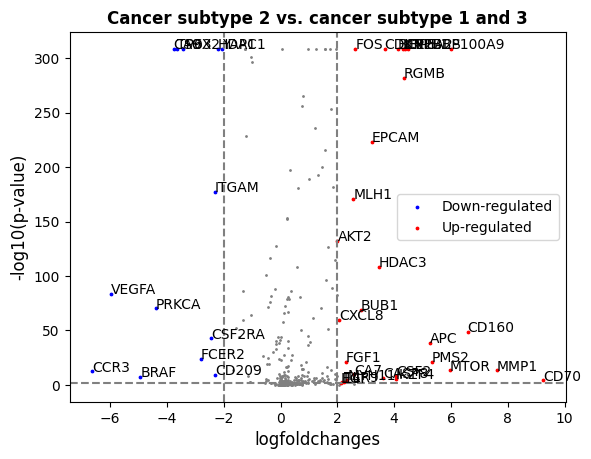

In [106]:
cancer_2_df = marker_df[marker_df['group'] == 'Cancer Subtype 2']

# Volcano plot
# plt.figure(figsize=(8, 6)) 
plt.scatter(x=cancer_2_df['logfoldchanges'], 
            y=cancer_2_df['-log10(pvals_adj)'],
            s=1,
            color='grey')
plt.title('Cancer subtype 2 vs. cancer subtype 1 and 3', fontweight='bold')

# highlight down- or up- regulated genes
down = cancer_2_df[(cancer_2_df['logfoldchanges']<=-2)&(cancer_2_df['pvals_adj']<=0.01)]
up = cancer_2_df[(cancer_2_df['logfoldchanges']>=2)&(cancer_2_df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],
            y=down['-log10(pvals_adj)'],
            s=3,
            label="Down-regulated",
            color="blue")
plt.scatter(x=up['logfoldchanges'],
            y=up['-log10(pvals_adj)'],
            s=3,
            label="Up-regulated",
            color="red")

# Label points
for i,r in down.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])
    
for i,r in up.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])

# # Label points
# down_label = pd.concat([down[np.isin(down['names'], oncogenes)], down[np.isin(down['names'], tumor_suppressor)]])
# for i,r in down_label.iterrows():
#     plt.text(x=r['logfoldchanges'],
#              y=-np.log10(r['pvals_adj']),
#              s=r['names'])
    
up_label = pd.concat([up[np.isin(up['names'], oncogenes)], up[np.isin(up['names'], tumor_suppressor)]])
for i,r in up_label.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])

plt.xlabel("logfoldchanges", fontsize=12)
plt.ylabel("-log10(p-value)", fontsize=12)
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

In [107]:
# Upregulated gene list
print(*list(up[up['-log10(pvals_adj)'] != np.inf]['names']), sep=', ')

S100A9, EPHA2, FOS, BCL2L1, CXCL8, CD160, IL4, EGF, TLR9, CD70, MYH11, IKZF4, CASP8, CSF2, CA7, MMP1, MTOR, PMS2, FGF1, APC, BUB1, HDAC3, AKT2, MLH1, EPCAM, RGMB, CDKN1B, CREBBP, LRP5


In [109]:
print('Oncogenes')
for i in list(up['names']):
    if i in oncogenes:
        print(i)
print()
print('Tumor suppressors')
for i in list(up['names']):
    if i in tumor_suppressor:
        print(i)

Oncogenes

Tumor suppressors


In [108]:
# Downregulated gene list
print(*list(down[down['-log10(pvals_adj)'] != np.inf]['names']), sep=', ')

ITGAM, PRKCA, CSF2RA, FCER2, CD209, BRAF, CCR3, VEGFA, YAP1, HDAC1, SOX2, CA9, TP63


In [110]:
print('Oncogenes')
for i in list(down['names']):
    if i in oncogenes:
        print(i)
print()
print('Tumor suppressors')
for i in list(down['names']):
    if i in tumor_suppressor:
        print(i)

Oncogenes
BRAF
SOX2

Tumor suppressors
TP63


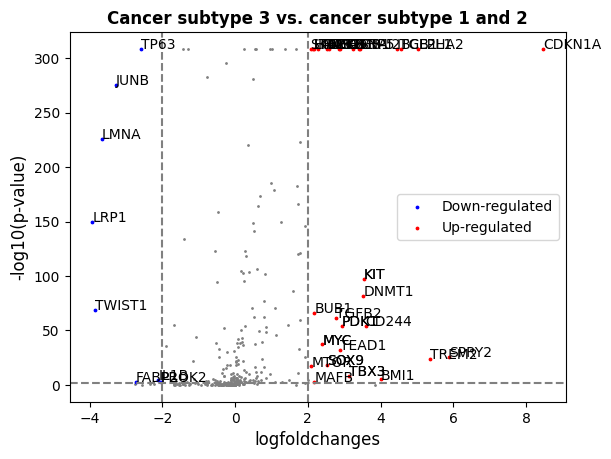

In [112]:
cancer_3_df = marker_df[marker_df['group'] == 'Cancer Subtype 3']

# Volcano plot
# plt.figure(figsize=(8, 6)) 
plt.scatter(x=cancer_3_df['logfoldchanges'], 
            y=cancer_3_df['-log10(pvals_adj)'],
            s=1,
            color='grey')
plt.title('Cancer subtype 3 vs. cancer subtype 1 and 2', fontweight='bold')

# highlight down- or up- regulated genes
down = cancer_3_df[(cancer_3_df['logfoldchanges']<=-2)&(cancer_3_df['pvals_adj']<=0.01)]
up = cancer_3_df[(cancer_3_df['logfoldchanges']>=2)&(cancer_3_df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],
            y=down['-log10(pvals_adj)'],
            s=3,
            label="Down-regulated",
            color="blue")
plt.scatter(x=up['logfoldchanges'],
            y=up['-log10(pvals_adj)'],
            s=3,
            label="Up-regulated",
            color="red")

# Label points
for i,r in down.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])
    
for i,r in up.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])

# # Label points
# down_label = pd.concat([down[np.isin(down['names'], oncogenes)], down[np.isin(down['names'], tumor_suppressor)]])
# for i,r in down_label.iterrows():
#     plt.text(x=r['logfoldchanges'],
#              y=-np.log10(r['pvals_adj']),
#              s=r['names'])
    
up_label = pd.concat([up[np.isin(up['names'], oncogenes)], up[np.isin(up['names'], tumor_suppressor)]])
for i,r in up_label.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])

plt.xlabel("logfoldchanges", fontsize=12)
plt.ylabel("-log10(p-value)", fontsize=12)
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

In [113]:
# Upregulated gene list
print(*list(up[up['-log10(pvals_adj)'] != np.inf]['names']), sep=', ')

ITGB1, CDKN1A, EPHA2, EGFR, CA9, BCL2L1, HRAS, LAMB3, SNAI2, PDK1, MYC, TEAD1, SPRY2, SOX9, TBX3, MAFB, BMI1, MTOR, TREM2, CD244, TGFB2, BUB1, DNMT1, KIT, NFKB1, RGMB, EGR1, KITLG, STAT3, LRP5


In [115]:
print('Oncogenes')
for i in list(up['names']):
    if i in oncogenes:
        print(i)
print()
print('Tumor suppressors')
for i in list(up['names']):
    if i in tumor_suppressor:
        print(i)

Oncogenes
EGFR
HRAS
PDK1
MYC
SOX9
TBX3
KIT

Tumor suppressors


In [114]:
# Downregulated gene list
print(*list(down[down['-log10(pvals_adj)'] != np.inf]['names']), sep=', ')

LRP1, IL1B, PROK2, FABP2, TWIST1, LMNA, JUNB, TP63


In [116]:
print('Oncogenes')
for i in list(down['names']):
    if i in oncogenes:
        print(i)
print()
print('Tumor suppressors')
for i in list(down['names']):
    if i in tumor_suppressor:
        print(i)

Oncogenes
TWIST1

Tumor suppressors
TP63


In [64]:
region_adata = ad.read(f'/mnt/nkeener/test_data/human_tumor/lung/labeled_adata_patient2_new_filters_fixed.h5ad')
region_adata.obs

,volume,z0_coords,z1_coords,z2_coords,z3_coords,z4_coords,z5_coords,z_count,n_genes_by_counts,log1p_n_genes_by_counts,...,pct_counts_in_top_500_genes,n_counts,n_genes,leiden_main,cell_type_manual_major,int_type,leiden,cell_type_manual_minor1,cell_type_manual_minor2,cell_type_manual_minor3
3256265,14469.0,56429_95229,56431_95232,56432_95235,56433_95236,56435_95237,56437_95239,6,94,4.553877,...,100.0,262.0,94,9,Endothelial,1,0,Blood vessels,NaN,NaN
563636,15713.0,48865_39057,48866_39054,48867_39052,48868_39047,48869_39043,48872_39042,6,53,3.988984,...,100.0,77.0,53,9,Endothelial,1,0,Blood vessels,NaN,NaN
3145072,4432.0,0,48211_62431,48212_62430,0,0,0,2,28,3.367296,...,100.0,42.0,28,9,Endothelial,1,0,Blood vessels,NaN,NaN
2713464,13014.0,4140_33987,4128_33983,4126_33984,4125_33983,0,0,4,110,4.709530,...,100.0,286.0,110,9,Endothelial,1,0,Blood vessels,NaN,NaN
3113255,30502.0,44008_94589,44013_94586,44016_94582,44018_94579,44021_94576,44025_94570,6,110,4.709530,...,100.0,289.0,110,9,Endothelial,1,0,Blood vessels,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824652,54432.0,0,19586_64967,19604_64987,19611_64995,19617_65003,19624_64998,5,121,4.804021,...,100.0,252.0,121,1,Epithelial,1,0,Cancer Epithelial,Cancer Subtype 2,NaN
3250862,2132.0,0,0,0,0,0,55988_81380,1,31,3.465736,...,100.0,41.0,31,0,Epithelial,1,0,Cancer Epithelial,Cancer Subtype 2,NaN
1258101,4076.0,69956_72757,69958_72761,69959_72761,0,0,0,3,49,3.912023,...,100.0,72.0,49,2,Epithelial,1,0,Cancer Epithelial,Cancer Subtype 2,NaN
1640420,48579.0,58772_99582,58770_99589,58769_99589,0,0,0,3,161,5.087596,...,100.0,579.0,161,1,Epithelial,1,0,Cancer Epithelial,Cancer Subtype 2,NaN


In [66]:
# Create dictionary mapping of cell index to cell integer type
minor1 = list(region_adata.obs['cell_type_manual_minor1'])
region_adata.obs['cell_type_manual_minor2'] = [celltype if celltype == celltype else minor1[c] for c, celltype in enumerate(region_adata.obs['cell_type_manual_minor2'])]

name_map = {'Cancer Subtype 1': 'Cancer Subtype 1',
            'Cancer Subtype 2': 'Cancer Subtype 2',
            'Cancer Subtype 3': 'Cancer Subtype 3',
            'Alveolar Epithelium': 'Alveolar Epithelial',
            'B cell lineage': 'B-cells',
            'T cell lineage': 'T-cells',
            'Dendritic cells': 'Dendritic cells',
            'Macrophages': 'Macrophages',
            'Monocytes': 'Monocytes',
            'Mast cells': 'Mast cells',
            'Fibroblast lineage': 'Fibroblasts',
            'Smooth muscle': 'Smooth muscle',
            'Blood vessels': 'Blood vessels',
            'Lymphatic EC': 'Lymphatic EC',
            'Mesothelium': 'Mesothelium',
            'Unassigned': 'Unassigned'}
region_adata.obs['new_ann'] = [name_map[celltype] for celltype in region_adata.obs['cell_type_manual_minor2']]
region_adata.obs['new_ann'] = pd.Categorical(region_adata.obs['new_ann'])

In [67]:
Counter(region_adata.obs['new_ann'])

Counter({'Blood vessels': 10073,
         'Lymphatic EC': 614,
         'T-cells': 89099,
         'B-cells': 40172,
         'Macrophages': 47780,
         'Dendritic cells': 3843,
         'Mast cells': 2646,
         'Smooth muscle': 8437,
         'Fibroblasts': 38514,
         'Cancer Subtype 1': 245122,
         'Cancer Subtype 2': 570339})

In [68]:
# Subset for each cancer region
cancer_1 = region_adata[np.isin(region_adata.obs['new_ann'], ['Cancer Subtype 1'])]
cancer_1.obs['1_vs_2'] = 'cancer_1'

cancer_2 = region_adata[np.isin(region_adata.obs['new_ann'], ['Cancer Subtype 2'])]
cancer_2.obs['1_vs_2'] = 'cancer_2'

# Combine
cancer_12 = sc.concat([cancer_1, cancer_2])

cancer_12

/tmp/ipykernel_20493/2330393314.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cancer_1.obs['1_vs_2'] = 'cancer_1'
/tmp/ipykernel_20493/2330393314.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cancer_2.obs['1_vs_2'] = 'cancer_2'


AnnData object with n_obs × n_vars = 815461 × 482
    obs: 'volume', 'z0_coords', 'z1_coords', 'z2_coords', 'z3_coords', 'z4_coords', 'z5_coords', 'z_count', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'leiden_main', 'cell_type_manual_major', 'int_type', 'leiden', 'cell_type_manual_minor1', 'cell_type_manual_minor2', 'cell_type_manual_minor3', 'new_ann', '1_vs_2'
    obsm: 'X_pca', 'X_umap'

In [69]:
# Find the most differentially expressed genes between cancer 1 and cancer 2
sc.tl.rank_genes_groups(cancer_12, '1_vs_2', method='wilcoxon')
marker_df = sc.get.rank_genes_groups_df(cancer_12, group=None)

# Add -log10(pvals_adj) column
pmin = np.min(marker_df[marker_df['pvals_adj'] != 0]['pvals_adj'])
marker_df['pvals_adj'] = [pval if pval > 10**-308 else pmin for pval in marker_df['pvals_adj']]
marker_df['-log10(pvals_adj)'] = -np.log10(marker_df['pvals_adj'])

marker_df

/mnt/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/mnt/envs/squidpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


,group,names,scores,logfoldchanges,pvals,pvals_adj,-log10(pvals_adj)
0,cancer_1,JUNB,382.884796,NaN,0.0,1.420466e-297,296.847569
1,cancer_1,VEGFA,286.018127,NaN,0.0,1.420466e-297,296.847569
2,cancer_1,NDUFA4L2,284.487396,NaN,0.0,1.420466e-297,296.847569
3,cancer_1,EGR1,269.587250,NaN,0.0,1.420466e-297,296.847569
4,cancer_1,CDKN1A,237.178894,NaN,0.0,1.420466e-297,296.847569
...,...,...,...,...,...,...,...
959,cancer_2,CDKN1A,-237.178894,NaN,0.0,1.420466e-297,296.847569
960,cancer_2,EGR1,-269.587250,NaN,0.0,1.420466e-297,296.847569
961,cancer_2,NDUFA4L2,-284.487396,NaN,0.0,1.420466e-297,296.847569
962,cancer_2,VEGFA,-286.018127,NaN,0.0,1.420466e-297,296.847569


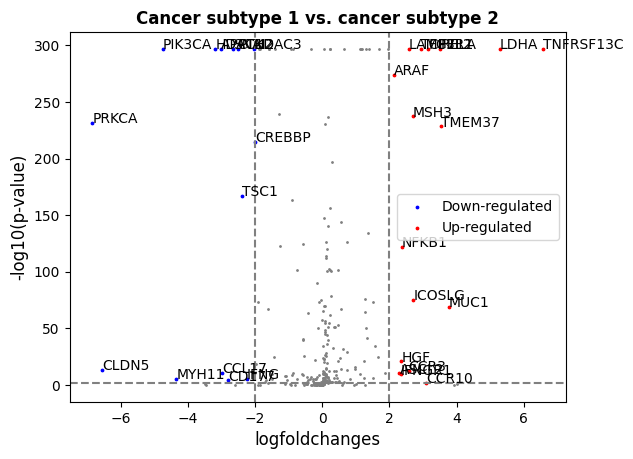

In [70]:
cancer_1_df = marker_df[marker_df['group'] == 'cancer_1']

# Volcano plot
# plt.figure(figsize=(8, 6)) 
plt.scatter(x=cancer_1_df['logfoldchanges'], 
            y=cancer_1_df['-log10(pvals_adj)'],
            s=1,
            color='grey')
plt.title('Cancer subtype 1 vs. cancer subtype 2', fontweight='bold')

# highlight down- or up- regulated genes
down = cancer_1_df[(cancer_1_df['logfoldchanges']<=-2)&(cancer_1_df['pvals_adj']<=0.01)]
up = cancer_1_df[(cancer_1_df['logfoldchanges']>=2)&(cancer_1_df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],
            y=down['-log10(pvals_adj)'],
            s=3,
            label="Down-regulated",
            color="blue")
plt.scatter(x=up['logfoldchanges'],
            y=up['-log10(pvals_adj)'],
            s=3,
            label="Up-regulated",
            color="red")

# Label points
for i,r in down.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])
    
for i,r in up.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])

# # Label points
# down_label = pd.concat([down[np.isin(down['names'], oncogenes)], down[np.isin(down['names'], tumor_suppressor)]])
# for i,r in down_label.iterrows():
#     plt.text(x=r['logfoldchanges'],
#              y=-np.log10(r['pvals_adj']),
#              s=r['names'])
    
up_label = pd.concat([up[np.isin(up['names'], oncogenes)], up[np.isin(up['names'], tumor_suppressor)]])
for i,r in up_label.iterrows():
    plt.text(x=r['logfoldchanges'],
             y=-np.log10(r['pvals_adj']),
             s=r['names'])

plt.xlabel("logfoldchanges", fontsize=12)
plt.ylabel("-log10(p-value)", fontsize=12)
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

In [72]:
# Upregulated gene list
print(*list(up[up['-log10(pvals_adj)'] != np.inf]['names']), sep=', ')

LDHA, RELA, LAMP3, TCF7L2, MUC1, CCR3, ASCL2, IFNGR1, CCR10, HGF, ICOSLG, NFKB1, TMEM37, MSH3, ARAF, FGFR1, TNFRSF13C


In [75]:
print('Oncogenes')
for i in list(up['names']):
    if i in oncogenes:
        print(i)
print()
print('Tumor suppressors')
for i in list(up['names']):
    if i in tumor_suppressor:
        print(i)

Oncogenes

Tumor suppressors


In [73]:
# Downregulated gene list
print(*list(down[down['-log10(pvals_adj)'] != np.inf]['names']), sep=', ')

CLDN5, CCL17, IFNG, CD177, MYH11, TSC1, CREBBP, PRKCA, SNAI2, HDAC3, APC, PIK3CA, PTK2, HDAC1


In [74]:
print('Oncogenes')
for i in list(down['names']):
    if i in oncogenes:
        print(i)
print()
print('Tumor suppressors')
for i in list(down['names']):
    if i in tumor_suppressor:
        print(i)

Oncogenes

Tumor suppressors


In [83]:
Counter(region_adata.obs['cell_type_manual_minor2'])

Counter({'Blood vessels': 10073,
         'Lymphatic EC': 614,
         'T cell lineage': 89099,
         'B cell lineage': 40172,
         'Macrophages': 47780,
         'Dendritic cells': 3843,
         'Mast cells': 2646,
         'Smooth muscle': 8437,
         'Fibroblast lineage': 38514,
         'Cancer Subtype 1': 245122,
         'Cancer Subtype 2': 570339})